**Part 1 & 2**
**Imports and dataset download,**
**Normalize data to [-0.5,0.5]**

In [1]:
import torch
import torch.nn as nn
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms as tvtf
import os
import time

# Determine which device to use, GPU or CPU (use GPU is avaliable)
dev = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(dev)
if dev is 'cuda':
    dtype = torch.cuda.FloatTensor
else:
    dtype = torch.FloatTensor
print(f'Using device {device}')

Using device cuda


In [2]:
# Normalize the data by substracting 0.5 from each image so the image range is now [-0.5,0.5]
def normalize(img):
  return img - 0.5

# Labels of the data
cfar10_labels = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Download data 
data_root = os.path.expanduser('~/.pytorch-datasets')

ds_train = torchvision.datasets.CIFAR10(root=data_root, download=True, train=True, transform=tvtf.Compose([tvtf.ToTensor(), normalize]))
ds_test = torchvision.datasets.CIFAR10(root=data_root, download=True, train=False, transform=tvtf.Compose([tvtf.ToTensor(), normalize]))
print(f'Train: {len(ds_train)} samples')
print(f'Test: {len(ds_test)} samples')


Extracting /root/.pytorch-datasets/cifar-10-python.tar.gz to /root/.pytorch-datasets
Files already downloaded and verified
Train: 50000 samples
Test: 10000 samples


**Part 3 Linear model without regularization**


In [3]:
# A few function to help later

# Calculate the accuracy of one batch by using the original y and the predicted y
def accuracy(y_pred, y):
  num_correct = (y == y_pred).sum() 
  total = y.shape[0]
  acc = float(num_correct) / total
  return acc

# Calculate the test set accuracy of the model 
def test_accuracy(model, dl_test, flat=True, dtype=torch.FloatTensor):
  with torch.no_grad(): # Dont calculate grad because no update of the weight is requeired
      test_acc = 0
      # Go over all batches in the test set
      for batch_samples in dl_test:
        # If we use Linear model we need to flatten the input, otherwise don't flatten (conv net)
        if flat:
          x = batch_samples[0].flatten(1).type(dtype)
        else:
          x = batch_samples[0].type(dtype)
        y = batch_samples[1].type(dtype)

        # Forward
        output = model(x)

        # Calculate batch accuracy
        test_acc += accuracy(torch.argmax(output, 1), y)
      return test_acc / len(dl_test)

# Transfer model weights to be in the shape of an image (for linear model)
def weights_as_images(model, img_shape):
  w = model.weight # weights of the first layer (Linear layer)
  w_images = w.reshape(w.shape[0], *img_shape)
  return w_images

# Show a batch of images (will be used to display the weights images)
def show_images(images):
  images = images.cpu().detach().numpy()
  fig, axes = plt.subplots(2,5, figsize=(15,5))
  for i, image in enumerate(images):
    img = (image - np.min(image))
    img /= np.max(img)
    k = i // 5
    j = i % 5
    axes[k, j].set_title(cfar10_labels[i])
    axes[k, j].imshow(img.transpose(1,2,0))
  plt.setp(axes, xticks=[], yticks=[])
  plt.show()

In [8]:
# Hyperparameters
batch_size = 32
lr = 3e-5
num_epochs = 25

# Linear model - please note that in pytorch softmax layer is inside the cross entropy
# loss layer, so we don't need to add it here seperately
model = nn.Linear(32*32*3, 10, bias=True)
print(model)


# Data loaders for train and test sets
dl_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=True, num_workers=2)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size, shuffle=False, num_workers=2)

# Loss function (inculdes softmax inside)
loss_fn = nn.CrossEntropyLoss()

# Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


Linear(in_features=3072, out_features=10, bias=True)


In [9]:
# Training the model (used for linear and conv models)
def train_model(model, dl_train, dl_test, optimizer, loss_fn,  num_ephocs, flat=True, dtype=torch.FloatTensor):
  '''
  input model - the model we use for training
  input dl_train - data loader for train set
  input dl_test - data loader for test set
  input optimizer - optimizer for training
  input loss_fn - the loss function 
  input num_ephocs - number of training epochs
  input flat - determine if we need to flatten the input before the forward pass (Only for linear model training)
  input dtype - data type of the model (this is used to move model and input to gpu or cpu)
  output epoch_losses - array of losses of each epoch
  output epochs_train_accuracy - array of training accuracy of each epoch
  output epochs_test_accuracy - array of test accuracy of each epoch

  '''
  model.type(dtype) # move model to gpu or cpu and change its type to float tensor
  epoch_losses = []
  epochs_train_accuracy = []
  epochs_test_accuracy = []

  # Train for num_epochs epochs
  for epoch in range(num_epochs):
    epoch_loss = 0
    start_time = time.time()
    batches_acc = 0
    # Loop over all dl batches
    for batch_samples in dl_train:
      optimizer.zero_grad() # zero the gradient each iteration
      # Flatten the input if we train linear model
      if flat:
        x = batch_samples[0].flatten(1).type(dtype)
      else:
        x = batch_samples[0].type(dtype)
      y = batch_samples[1].type(dtype)

      # Forward
      output = model(x)

      # Loss 
      loss = loss_fn(output, y.long())
      #print(loss.item())

      # Backward
      loss.backward()

      # Update step
      optimizer.step()
      epoch_loss += loss.item()

      batches_acc += accuracy(torch.argmax(output, 1), y)

    epochs_train_accuracy.append(batches_acc / len(dl_train))

    epoch_losses.append(epoch_loss / len(dl_train))

    test_acc = test_accuracy(model, dl_test, flat, dtype)
    epochs_test_accuracy.append(test_acc)
    
    epoch_time = time.time() - start_time
    print(f'Epoch {epoch} : Loss = {epoch_losses[-1]},  Train Accuracy = {epochs_train_accuracy[-1]},  Test Accuracy = {epochs_test_accuracy[-1]}  Time = {epoch_time}')
  return epoch_losses, epochs_train_accuracy, epochs_test_accuracy

In [10]:
# Train the model
epoch_losses, epochs_train_accuracy, epochs_test_accuracy = train_model(model, dl_train, dl_test, optimizer, loss_fn, num_epochs)

Epoch 0 : Loss = 1.98314440204635,  Train Accuracy = 0.32321657069737686,  Test Accuracy = 0.35493210862619806  Time = 10.212130784988403
Epoch 1 : Loss = 1.8544503534290169,  Train Accuracy = 0.37150111964171467,  Test Accuracy = 0.37769568690095845  Time = 9.786714315414429
Epoch 2 : Loss = 1.8177461506690418,  Train Accuracy = 0.3844169865642994,  Test Accuracy = 0.38099041533546324  Time = 9.674796342849731
Epoch 3 : Loss = 1.7968602113363763,  Train Accuracy = 0.3910948496481126,  Test Accuracy = 0.3889776357827476  Time = 9.953856706619263
Epoch 4 : Loss = 1.7818956074620087,  Train Accuracy = 0.3972128918746001,  Test Accuracy = 0.3909744408945687  Time = 9.951985836029053
Epoch 5 : Loss = 1.7704692509261295,  Train Accuracy = 0.4020713371721049,  Test Accuracy = 0.3966653354632588  Time = 9.643319368362427
Epoch 6 : Loss = 1.7610692045891505,  Train Accuracy = 0.40493042226487524,  Test Accuracy = 0.39456869009584666  Time = 9.816377639770508
Epoch 7 : Loss = 1.7531143598501604

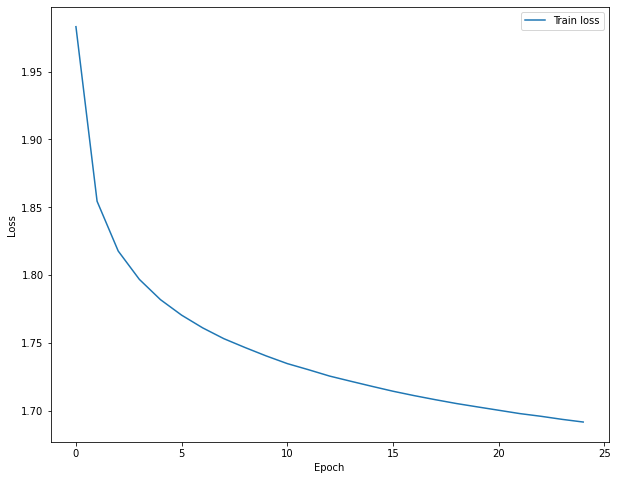

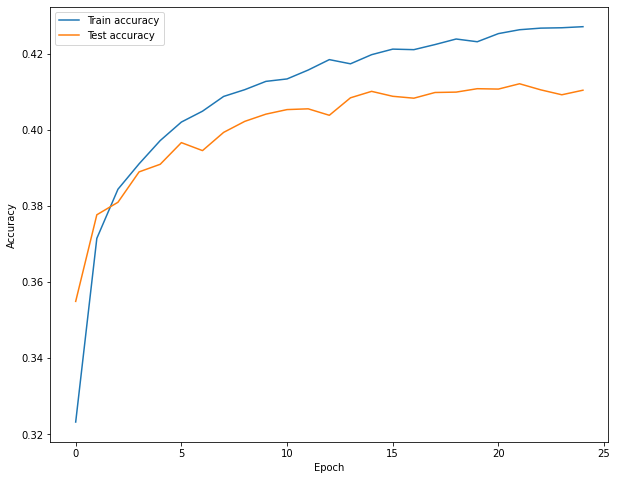

In [11]:
# Function to plot losses and accuracies graphs
def plot_graphs(epoch_losses, epochs_train_accuracy, epochs_test_accuracy):
  plt.figure(figsize=(10, 8))
  plt.plot(epoch_losses, label=f'Train loss')
  plt.legend()
  plt.ylabel("Loss")
  plt.xlabel("Epoch")
  plt.show()

  plt.figure(figsize=(10, 8))
  plt.plot(epochs_train_accuracy, label=f'Train accuracy')
  plt.plot(epochs_test_accuracy, label=f'Test accuracy')
  plt.legend()
  plt.ylabel("Accuracy")
  plt.xlabel("Epoch")
  plt.show()

plot_graphs(epoch_losses, epochs_train_accuracy, epochs_test_accuracy)

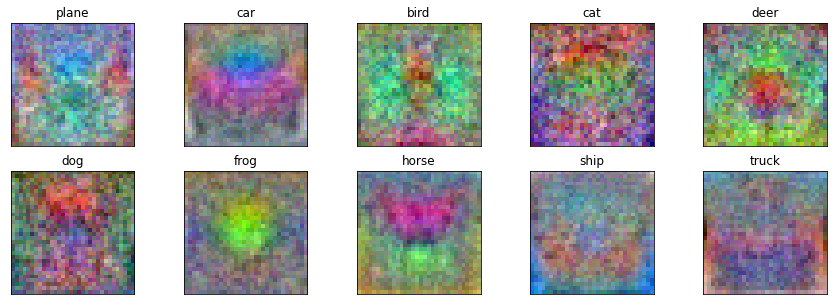

In [12]:
# Display linear model weights as images
show_images(weights_as_images(model, (3,32,32)))

**Part 4 Linear model with L2 regularization**

In [9]:
# Hyperparameters
batch_size = 32
lr = 4e-5
num_epochs = 7
reg = 0.1

# Model - sofmax is included in cross entropy loss
model = nn.Linear(32*32*3,10, bias=True)

# Data loaders
dl_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=False)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size, shuffle=False)

# Loss function
loss_fn = nn.CrossEntropyLoss()

# Adam optimizer with regularization
# L2 regularization in pytorch is determined by weight decay in optimzier
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=reg)



In [10]:
# Train model
epoch_losses, epochs_train_accuracy, epochs_test_accuracy = train_model(model, dl_train, dl_test, optimizer, loss_fn, num_epochs)

Epoch 0 : Loss = 1.9758503041966025,  Train Accuracy = 0.3232965451055662,  Test Accuracy = 0.3597244408945687  Time = 8.701382398605347
Epoch 1 : Loss = 1.8702599023750632,  Train Accuracy = 0.3699216250799744,  Test Accuracy = 0.3730031948881789  Time = 8.575548887252808
Epoch 2 : Loss = 1.8505615175952532,  Train Accuracy = 0.3778190978886756,  Test Accuracy = 0.37689696485623003  Time = 8.526841402053833
Epoch 3 : Loss = 1.8429678196489085,  Train Accuracy = 0.38175783749200254,  Test Accuracy = 0.3784944089456869  Time = 8.538558721542358
Epoch 4 : Loss = 1.8393487325480407,  Train Accuracy = 0.38317738323736406,  Test Accuracy = 0.37879392971246006  Time = 8.567289352416992
Epoch 5 : Loss = 1.8373866824865799,  Train Accuracy = 0.38375719769673705,  Test Accuracy = 0.378694089456869  Time = 8.685391187667847
Epoch 6 : Loss = 1.8362130858695287,  Train Accuracy = 0.38429702495201534,  Test Accuracy = 0.37879392971246006  Time = 8.526066303253174


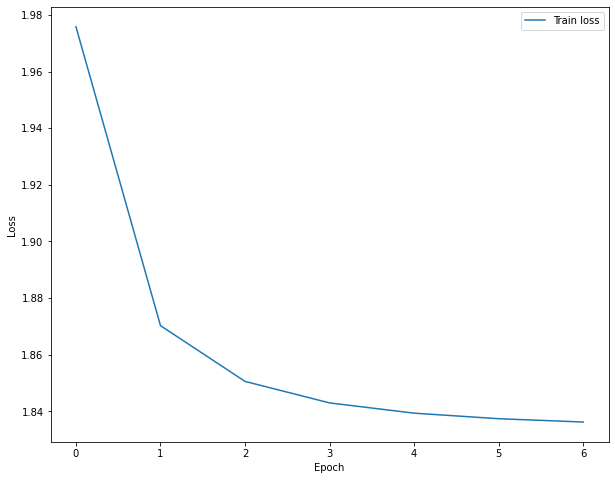

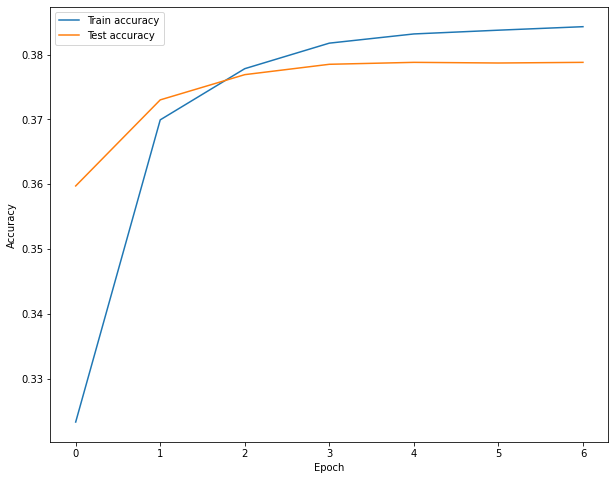

In [11]:
# Plot losses and accuracies graphs
plot_graphs(epoch_losses, epochs_train_accuracy, epochs_test_accuracy)

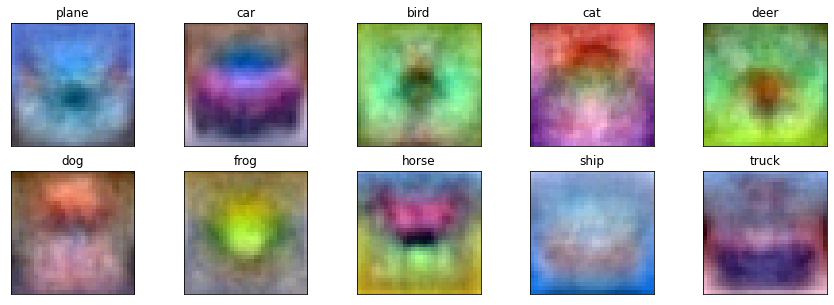

In [12]:
# Display Linear model weights as images
show_images(weights_as_images(model, (3,32,32)))

**Part 5 Conv net**

In [13]:
# Convolution network 
class LeNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.feature_extarctor = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, stride=1, bias=True), nn.ReLU(), nn.MaxPool2d(2, 2), 
                                            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1, bias=True), nn.ReLU(), nn.MaxPool2d(2, 2))
    self.classifier = nn.Sequential(nn.Linear(16*6*6, 120, bias=True), nn.ReLU(), 
                                    nn.Linear(120, 84, bias=True), nn.ReLU(), 
                                    nn.Linear(84, 10, bias=True))
  def forward(self, x):
    features = self.feature_extarctor(x)
    flat = features.flatten(1)
    probs = self.classifier(flat)
    return probs

  def inference(self, x):
    softmax = nn.Softmax(dim=1)
    with torch.no_grad():
      output = model(x)
      probs = softmax(output)
      y_pred = torch.argmax(output, 1)
    return y_pred, probs



In [14]:
# Hyperparameters
batch_size = 32
lr = 0.0001
num_epochs = 70

# Model
model = LeNet()
print(model)

# Data loaders
dl_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=True, num_workers=2)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size, shuffle=False, num_workers=2)

# Loss function
loss_fn = nn.CrossEntropyLoss()

# Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


LeNet(
  (feature_extarctor): Sequential(
    (0): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=576, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)


In [15]:
# Train model
epoch_losses, epochs_train_accuracy, epochs_test_accuracy = train_model(model, dl_train, dl_test, optimizer, loss_fn, num_epochs, flat=False, dtype=dtype)

Epoch 0 : Loss = 1.9683025740539883,  Train Accuracy = 0.28660828534868843,  Test Accuracy = 0.3601238019169329  Time = 14.800068855285645
Epoch 1 : Loss = 1.702490309988621,  Train Accuracy = 0.3840171145233525,  Test Accuracy = 0.40644968051118213  Time = 14.635216236114502
Epoch 2 : Loss = 1.5959891261615131,  Train Accuracy = 0.41918586052463214,  Test Accuracy = 0.42991214057507987  Time = 14.660244464874268
Epoch 3 : Loss = 1.5340064302973464,  Train Accuracy = 0.44289827255278313,  Test Accuracy = 0.45097843450479236  Time = 14.829021215438843
Epoch 4 : Loss = 1.4916642185822557,  Train Accuracy = 0.4588531669865643,  Test Accuracy = 0.4619608626198083  Time = 14.90363621711731
Epoch 5 : Loss = 1.4563070447568471,  Train Accuracy = 0.47308861164427385,  Test Accuracy = 0.4796325878594249  Time = 14.687931299209595
Epoch 6 : Loss = 1.4243343978529166,  Train Accuracy = 0.48514475367882276,  Test Accuracy = 0.48761980830670926  Time = 14.735182046890259
Epoch 7 : Loss = 1.39615561

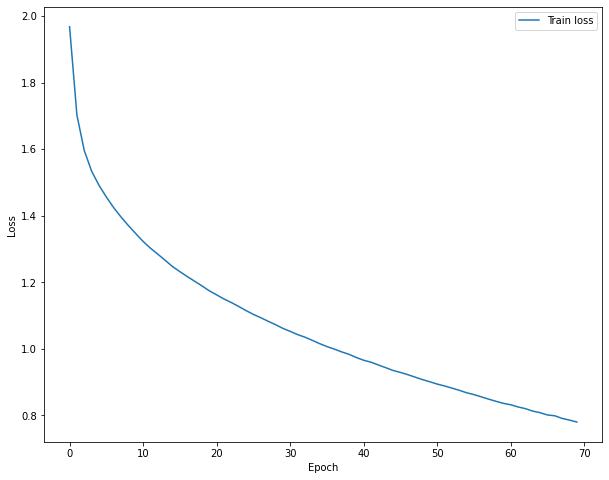

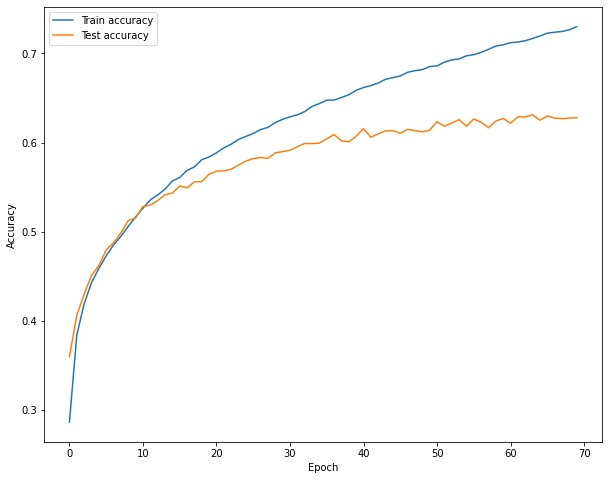

In [16]:
# PLot losses and accuracies graphs
plot_graphs(epoch_losses, epochs_train_accuracy, epochs_test_accuracy)

One batch from the training set


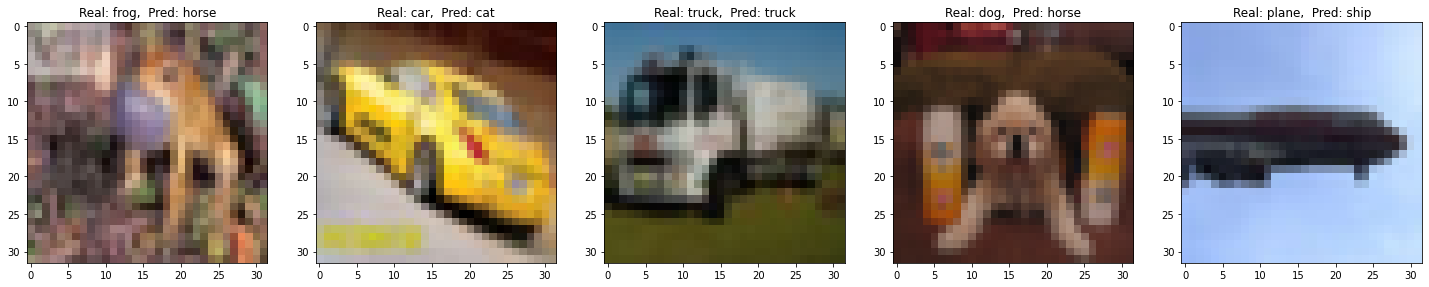

One batch from the test set


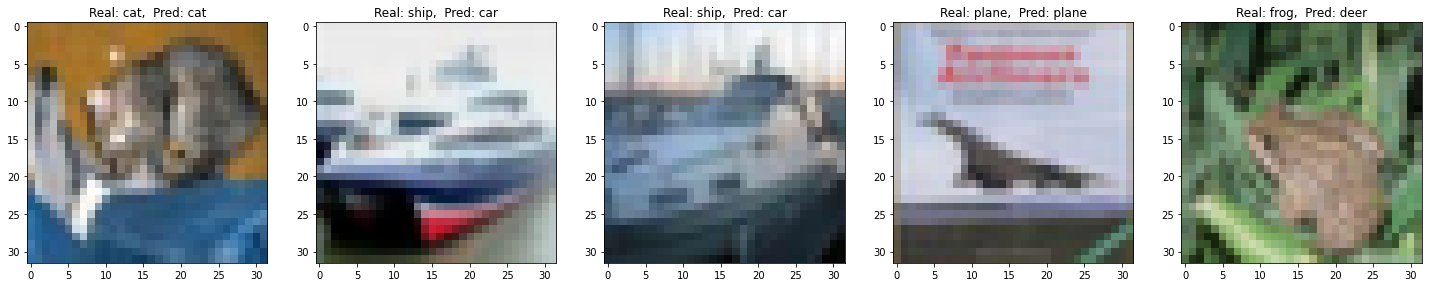

In [17]:
# Display one batch of results
def show_one_batch_results(model, dl, dtype):
  model.type(dtype)
  batch, y = next(iter(dl))
  with torch.no_grad():
    output = model(batch.type(dtype))
    y_pred = torch.argmax(output, dim=1)
  
  fig, ax = plt.subplots(1, 5, figsize=(25, 5))
  ax = ax.reshape([1, 5])
  for i in range(5):
    ax[0,i].set_title(f'Real: {cfar10_labels[y[i]]},  Pred: {cfar10_labels[y_pred[i]]}')
    ax[0,i].imshow(batch[i].cpu().numpy().transpose(1,2,0) + 0.5)

  plt.show()

print('One batch from the training set')
show_one_batch_results(model, dl_train, dtype)

print('One batch from the test set')
show_one_batch_results(model, dl_test, dtype)

**Part 6 Data augmantations**

In [18]:
# Define the transformations 
transforms = tvtf.Compose([tvtf.ToTensor(), normalize, tvtf.RandomHorizontalFlip(p=0.2), tvtf.RandomApply([tvtf.RandomResizedCrop(32, [0.6, 0.7, 0.8, 0.9])], p=0.2), tvtf.RandomPerspective(distortion_scale=0.2, p=0.2, fill=(0,))])

# Hyperparameters
batch_size = 32
lr = 0.0001
num_epochs = 70

# Model
model = LeNet()

# Define the transforms of the dataset 
ds_train.transform = transforms
print(ds_train.transform)

# Data loaders 
dl_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=True, num_workers=2)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size, shuffle=False, num_workers=2)

# Loss function
loss_fn = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

Compose(
    ToTensor()
    <function normalize at 0x7ff9f06799d8>
    RandomHorizontalFlip(p=0.2)
    RandomApply(
    p=0.2
    RandomResizedCrop(size=(32, 32), scale=(0.6, 0.7, 0.8, 0.9), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
)
    RandomPerspective(p=0.2)
)


In [19]:
# Ignore user warnings
import warnings
warnings.filterwarnings('ignore')

# Train model
epoch_losses, epochs_train_accuracy, epochs_test_accuracy = train_model(model, dl_train, dl_test, optimizer, loss_fn, num_epochs, flat=False, dtype=dtype)

Epoch 0 : Loss = 1.9899376366890476,  Train Accuracy = 0.2740323096609085,  Test Accuracy = 0.34185303514376997  Time = 25.21228790283203
Epoch 1 : Loss = 1.7744499431995726,  Train Accuracy = 0.3571857005758157,  Test Accuracy = 0.4097444089456869  Time = 25.250113248825073
Epoch 2 : Loss = 1.6551622315545305,  Train Accuracy = 0.398132597568778,  Test Accuracy = 0.4333067092651757  Time = 25.139920711517334
Epoch 3 : Loss = 1.5952366734649306,  Train Accuracy = 0.4194457773512476,  Test Accuracy = 0.446685303514377  Time = 25.423662185668945
Epoch 4 : Loss = 1.554634500831194,  Train Accuracy = 0.4374000319897633,  Test Accuracy = 0.4619608626198083  Time = 25.14643669128418
Epoch 5 : Loss = 1.5260463521332597,  Train Accuracy = 0.4477767114523353,  Test Accuracy = 0.47264376996805113  Time = 25.309510946273804
Epoch 6 : Loss = 1.498697007571896,  Train Accuracy = 0.4608125399872041,  Test Accuracy = 0.479732428115016  Time = 25.25429105758667
Epoch 7 : Loss = 1.4807235432296553,  Tr

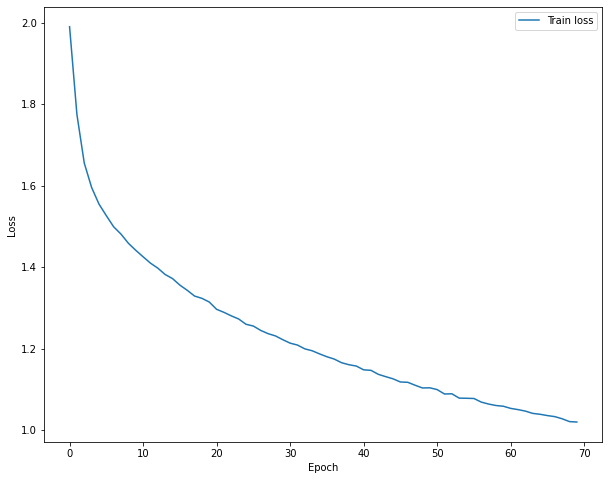

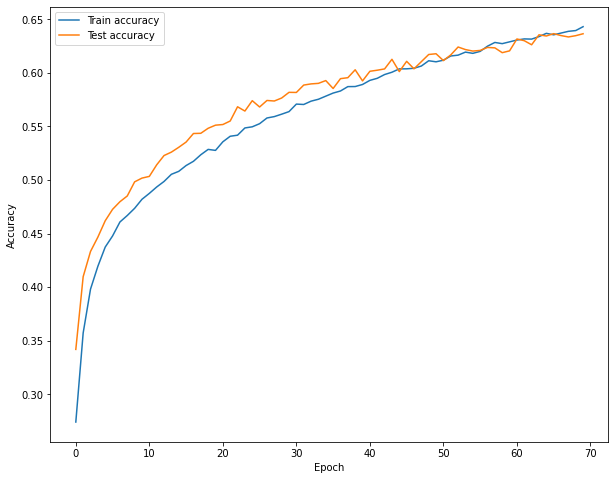

In [20]:
# Plot losses and accuracies graphs
plot_graphs(epoch_losses, epochs_train_accuracy, epochs_test_accuracy)

In [22]:
# Upload files to google colab
def upload_files():
  from google.colab import files
  uploaded = files.upload()
  for k, v in uploaded.items():
    open(k, 'wb').write(v)
  return list(uploaded.keys())

# Used to upload ship and dog images
upload_files()

Saving boat.jpg to boat (1).jpg
Saving Dog.jpg to Dog (1).jpg


['boat.jpg', 'Dog.jpg']

torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])


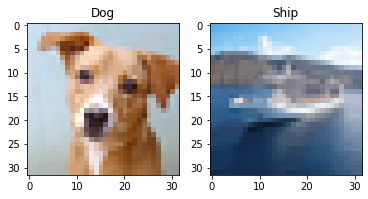

In [23]:
# Upload and resize the images
from PIL import Image
dog_image = Image.open('Dog.jpg')
dog_image = dog_image.resize((32,32), resample= Image.LANCZOS)
dog_img_tensor = tvtf.ToTensor()(dog_image).unsqueeze(0)
print(dog_img_tensor.shape)
ship_image = Image.open('boat.jpg')
ship_image = ship_image.resize((32,32), resample= Image.LANCZOS)
ship_img_tensor = tvtf.ToTensor()(ship_image).unsqueeze(0)
print(ship_img_tensor.shape)

# Display the images
fig, ax = plt.subplots(1, 2)
ax = ax.reshape([1, 2])
ax[0,0].set_title('Dog')
ax[0,0].imshow(dog_image)
ax[0,1].set_title('Ship')
ax[0,1].imshow(ship_image)
plt.show()


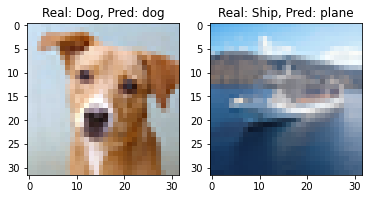

[('dog', 0.7756), ('cat', 0.1425), ('plane', 0.0295), ('horse', 0.0283), ('bird', 0.0136), ('deer', 0.0057), ('frog', 0.0023), ('ship', 0.0015), ('truck', 0.0009), ('car', 0.0001)]
[('plane', 0.6248), ('ship', 0.3658), ('bird', 0.0025), ('car', 0.0023), ('truck', 0.0021), ('deer', 0.0009), ('cat', 0.0006), ('horse', 0.0006), ('dog', 0.0003), ('frog', 0.0)]


In [29]:
# Use the model to predict the label of the images
input = torch.cat([dog_img_tensor, ship_img_tensor], dim=0).type(dtype)
y_pred, probs = model.inference(input)

# Display the results
fig, ax = plt.subplots(1, 2)
ax = ax.reshape([1, 2])
ax[0,0].set_title(f'Real: Dog, Pred: {cfar10_labels[y_pred[0]]}')
ax[0,0].imshow(dog_image)
ax[0,1].set_title(f'Real: Ship, Pred: {cfar10_labels[y_pred[1]]}')
ax[0,1].imshow(ship_image)
plt.show()

probs_dog = [(label, round(prob.item(), 4)) for prob, label in zip(probs[0], cfar10_labels)]
probs_dog.sort(key=lambda x: x[1], reverse=True)
print(probs_dog)
probs_ship = [(label, round(prob.item(), 4)) for prob, label in zip(probs[1], cfar10_labels)]
probs_ship.sort(key=lambda x: x[1], reverse=True)
print(probs_ship)